In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from statsmodels.tsa.stattools import coint

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('raw_data.csv', index_col = 0)
X = pd.read_csv('pairs_data.csv', index_col = 0)

In [17]:
kmeans = cluster.KMeans(4)
kmeans.fit(X)
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

In [34]:
ap_model_tuned = AffinityPropagation(damping = .5, max_iter = 200, convergence_iter = 10)
ap_labels_tuned = ap_model_tuned.fit_predict(X)
exemplars = ap_model_tuned.cluster_centers_indices_

In [35]:
clusters = pd.Series(index = X.index, data = ap_labels_tuned.flatten())
clusters = clusters[clusters != -1]
n_clusters = clusters.value_counts()[(clusters.value_counts() > 1) & (clusters.value_counts() <= 1000)]

In [36]:
def cointegrate(securities):
    s = securities.shape[1]
    score_mx = np.zeros((s, s))
    pval_mx = np.zeros((s, s))
    keys = securities.keys()
    pairs = []
    for i in range(1):
        for j in range(i + 1, s):
            p1, p2 = securities[keys[i]], securities[keys[j]]
            run = coint(p1, p2)
            score = run[0]
            pval = run[1]
            score_mx[i, j] = score
            pval_mx[i, j] = pval
            if pval < .05:
                pairs.append((keys[i], keys[j]))
    return score_mx, pval_mx, pairs

In [37]:
cluster_store = {}
for i, j in enumerate(n_clusters.index):
    tickers = clusters[clusters == j].index   
    score_mx, pval_mx, pairs = cointegrate(df[tickers])
    cluster_store[j] = {}
    cluster_store[j]['score_matrix'] = score_mx
    cluster_store[j]['pvalue_matrix'] = pval_mx
    cluster_store[j]['pairs'] = pairs

In [38]:
pairs = []
for i in cluster_store.keys():
    pairs.extend(cluster_store[i]['pairs'])
stocks = list(np.unique(pairs))

In [39]:
scaled_df = pd.DataFrame(index = X.index, data = X).T
pairs_ser = clusters.loc[stocks]
scaled_pairs = scaled_df.T.loc[stocks]
scaled_tsne = TSNE(learning_rate = 50, perplexity = 3, random_state = 42).fit_transform(scaled_pairs)

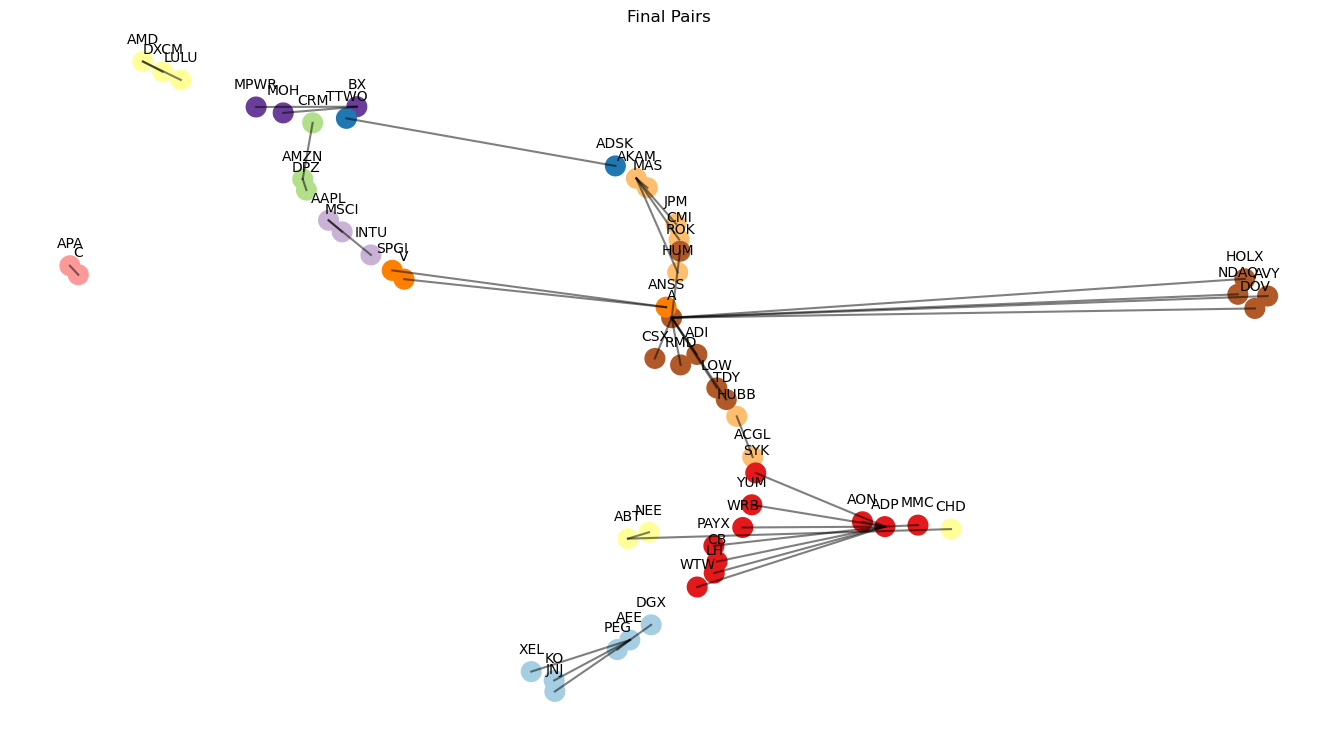

In [73]:
plt.figure(figsize = (17, 9))
plt.axis('off')
plt.title('Final Pairs')
for i in pairs:
    i0 = scaled_pairs.index.get_loc(i[0])
    x, y = scaled_tsne[i0, :]
    i1 = scaled_pairs.index.get_loc(i[1])
    u, w = scaled_tsne[i1, :]
    
    plt.plot([x, u], [y, w], 'k-', alpha = .5)
    
plt.scatter(scaled_tsne[:, 0], scaled_tsne[:, 1], s = 200, c = pairs_ser.values, cmap = cm.Paired)

    
for i, j, n in zip(scaled_tsne[:, 0], scaled_tsne[:, 1], scaled_pairs.index):
    plt.annotate(n, (i, j), textcoords = 'offset points', xytext = (0, 13), ha = 'center')
